## this is the first example: linear wave equation

In [1]:
# periodic bc wave equations
import tensorflow as tf
#import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sys
import time
import os
import h5py


2025-08-19 06:00:05.432235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-19 06:00:05.432262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-19 06:00:05.474531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-19 06:00:05.569106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-19 06:00:08.842480: W tensorflow/compiler/tf2

In [5]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

In [6]:
tf.keras.utils.set_random_seed(1) 
tf.config.experimental.enable_op_determinism()


dtype_=tf.float64
tf.keras.backend.set_floatx('float64')

In [7]:
#If there are GPUs, the first one is used by default
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:",gpus)
tf.config.set_visible_devices(gpus[0], 'GPU')
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']="true"   

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
curr_path = os.getcwd()   # the current directory
print(curr_path)

print(tf.__version__)

/global/u1/c/chen123/linear
2.15.0


### build the model

In [9]:

# the optional block of our symplectic NN, G-reflector
class SympMatLayer(layers.Layer):
    def __init__(self, nif):
        super(SympMatLayer, self).__init__()
        init = tf.initializers.GlorotNormal(seed=0)
        #init_zero = tf.zeros_initializer()

        self.nif = nif
        # beta_init = init(shape=[1,1], dtype = dtype_)
        # uvec_init = init(shape=[2*self.dim,1], dtype = dtype_)

        self.beta = self.add_weight(name = 'beta', shape=[1,1], initializer=init, trainable=True)

        self.uvec = self.add_weight(name = 'u', shape=[2*self.nif,1], initializer=init, trainable=True)


    @tf.function
    def call(self,z):
        zJt = tf.concat([z[:,self.nif:],-z[:,0:self.nif]], axis=1)
        out = z + self.beta*tf.matmul(tf.matmul(zJt, self.uvec), tf.transpose(self.uvec))
        return out

    '''
        Note the inverse of G is
        G^{-1} = I - beta u u^T J
        Comment: this is a nice property!
    '''
    @tf.function
    def inverse(self, z):
        zJt = tf.concat([z[:,self.nif:],-z[:,0:self.nif]], axis=1)
        out = z - self.beta*tf.matmul(tf.matmul(zJt, self.uvec), tf.transpose(self.uvec))
        return out
    

# great symp matrix with G-reflectors

class SympMat(Model):
    """
    N: number of G-reflectors
    nif: dim of full physical space
    nir: dim of reduced latent space
    """
    def __init__(self,N,nif,nir):
        super(SympMat, self).__init__()
        self.N = N
        self.nif = nif
        self.nir = nir
        self.hlayers=[]
        for i in range(self.N):
            hl = SympMatLayer(self.nif)
            self.hlayers.append(hl)


        self.paddings = tf.constant([[0,0], [0,self.nif-nir]])


    @tf.function
    def project(self, r):
        rout = r
        for i in range(self.N):
            rout = self.hlayers[i](rout)

        return tf.concat([rout[:,:self.nir],rout[:,self.nif:(self.nif+self.nir)]], axis=1)

    @tf.function
    def inverse(self, r):
        # K = r.shape[0]
        # d = self.nif-self.nir

        q = r[:,:self.nir]
        q = tf.pad(q, self.paddings, "CONSTANT")
        p = r[:,self.nir:]
        p = tf.pad(p, self.paddings, "CONSTANT")

        rout = tf.concat([q,p], axis=1)
        for i in range(self.N)[-1::-1]:
            rout = self.hlayers[i].inverse(rout)

        return rout


    @tf.function
    def call(self, r):
        rout = r

        # mask = np.ones_like(r.numpy())
        # mask[:,self.nir:self.nif] = 0.
        # mask[:,(self.nif+self.nir):] = 0.

        # mask = tf.constant(mask, dtype=tf.float64)

        for i in range(self.N):
            rout = self.hlayers[i](rout)

        # print( tf.concat([rout[:,:self.nir], tf.zeros_like(rout)[:,:(self.nif-self.nir)],rout[:,self.nif:(self.nif+self.nir)]], axis=1))
        # rout = rout*mask

        rout = tf.concat([rout[:,:self.nir], tf.zeros_like(rout)[:,:(self.nif-self.nir)],
                          rout[:,self.nif:(self.nif+self.nir)],
                          tf.zeros_like(rout)[:,:(self.nif-self.nir)]
                          ], axis=1)

        for i in range(self.N)[-1::-1]:
            rout = self.hlayers[i].inverse(rout)



        return rout
    

In [10]:
# the main block of our symplectic NN, HenonNets
#potential function
class Potential(layers.Layer):
    def __init__(self, units=5):
        super(Potential, self).__init__()
        self.units = units
        self.dense_1 = Dense(name='potential.1', units = self.units, activation='elu') # layer class Linear has to be defined before
        self.dense_2 = Dense(name='potential.2', units = self.units, activation='elu')
        self.out = Dense(1,use_bias=False) # output size is 1, no bias

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return self.out(x)


ymean_tf = tf.constant(0, dtype=tf.float64)
ydiam_tf = tf.constant(1., dtype=tf.float64)


class HenonLayer(layers.Layer):
    def __init__(self, units=10):
        super(HenonLayer, self).__init__()
        self.units = units
        self.V = Potential(self.units)

    def build(self, input_shape): # the input_shape is the shape of z in the call function
        self.eta = self.add_weight(name = 'eta', shape=(input_shape[-1]//2,), trainable=True)

    def call(self, z, inverse = False):
        if inverse:
            return self.inverse(z)
        return self.forward(z)

    @tf.function
    def forward(self, z):
        #ipdb.set_trace()
        ni = int(z.shape[-1]/2)
        X = z[:,:ni]
        Y = z[:,ni:]
        for k in range(4):
            with tf.GradientTape() as tape:
                tape.watch(Y)
                Ylast = (Y - ymean_tf) / ydiam_tf
                p = self.V(Ylast)

            Yout = -X + tape.gradient(p, Y)
            X = Y + self.eta
            Y = Yout

        return tf.concat([X,Y], axis = 1)
    @tf.function
    def inverse(self, z): # compute the inverse of the HenonLayer

        ni = int(z.shape[-1]/2)
        X = z[:,:ni]
        Y = z[:,ni:]
        for k in range(4):
            X = X - self.eta
            with tf.GradientTape() as tape:
                tape.watch(X)
                Xlast = (X - ymean_tf)/ydiam_tf
                p = self.V(Xlast)
            Ylast = X
            X = -Y + tape.gradient(p, X)
            Y = Ylast

        return tf.concat([X,Y], axis = 1)


class SympMatROM(Model):
    """
        units_list: the list of

    """
    def __init__(self, units_list, N, nif,nir):
        super(SympMatROM, self).__init__()
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.N = N
        self.nif = nif
        self.nir = nir
        self.matlayers = []
        self.henonlayers = []

        for i in units_list:
            hl = HenonLayer(i)
            self.henonlayers.append(hl)

        for i in range(self.N):
            ml = SympMatLayer(self.nif)
            self.matlayers.append(ml)


        self.paddings = tf.constant([[0,0], [0,self.nif-self.nir]])


    @tf.function
    def project(self, r):
        rout = r
        for i in range(len(self.henonlayers)):
            rout = self.henonlayers[i](rout)
        for i in range(self.N):
            rout = self.matlayers[i](rout)

        return tf.concat([rout[:,:self.nir],rout[:,self.nif:(self.nif+self.nir)]], axis=1)

    @tf.function
    def embedding(self, r):
        # K = r.shape[0]
        # d = self.nif-self.nir

        q = r[:,:self.nir]
        q = tf.pad(q, self.paddings, "CONSTANT")
        p = r[:,self.nir:]
        p = tf.pad(p, self.paddings, "CONSTANT")

        rout = tf.concat([q,p], axis=1)
        for i in range(self.N)[-1::-1]:
            rout = self.matlayers[i].inverse(rout)

        for i in range(len(self.henonlayers))[-1::-1]:
            rout = self.henonlayers[i].inverse(rout)

        return rout


    @tf.function
    def call(self, r):
        rout = r


        rout = self.project(rout)
        rout = self.embedding(rout)



        return rout

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            # WG: it means the loss is the loss supplied in compile?
            loss = self.compute_loss(y=y, y_pred=y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        # need to update the loss in loss_tracker
        self.loss_tracker.update_state(loss) # Add current batch loss

        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result()}




    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data


        y_pred = self(x, training=False)  # Forward pass
        loss = self.compute_loss(y=y, y_pred=y_pred)
        self.loss_tracker.update_state(loss) # Add current batch loss


        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result()}
        # return {"mae": self.mae_metric.result()}


2025-08-19 06:23:52.883636: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-08-19 06:23:52.885106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0


In [11]:
def hamiltonian(z):
  """
  compute the discrete hamiltonian, it depends on the concrete equation, and the physical space; aiming at computing the hamiltonian loss
  """
  w = 0.1 # wave speed
  delta_x = 1/200 # grid spacing
  q = z[:,:z.shape[-1]//2]# q
  p = z[:,z.shape[-1]//2:]# p
  q_r = tf.concat([q[:,1:],q[:,0:1]],axis=1)# q1-qN+1
  q_l = tf.concat([q[:,-1:],q[:,:-1]],axis=1)# q0-qN-1

  h = delta_x/2*tf.reduce_sum(p**2+w**2*(q_r-q)**2/(2*delta_x**2)+w**2*(q-q_l)**2/(2*delta_x**2),keepdims=True,axis=1)
  return h


In [16]:
class SympMatFlowMappingROM(Model):
    """
        units_list: the list of 

    """
    def __init__(self, units_list_ae, N, nif, nir, units_list_fm, n, n_train_time,lamb1):
        super(SympMatFlowMappingROM, self).__init__()
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.N = N
        self.nif = nif
        self.nir = nir
        self.matlayers_ae = []
        self.henonlayers_ae = []
        self.n = n
        self.matlayers_fm = []
        self.henonlayers_fm = []
        self.n_train_time = n_train_time
        self.lamb1 = lamb1 # balanced hamilton loss

        for i in units_list_ae:
            hl = HenonLayer(i)
            self.henonlayers_ae.append(hl)

        for i in range(self.N):
            ml = SympMatLayer(self.nif)
            self.matlayers_ae.append(ml)

        for i in units_list_fm:
            hl = HenonLayer(i)
            self.henonlayers_fm.append(hl)

        for i in range(self.n):
            ml = SympMatLayer(self.nir)
            self.matlayers_fm.append(ml)

        self.paddings = tf.constant([[0,0], [0,self.nif-self.nir]])

     
    @tf.function
    def project(self, r):
        rout = r
        for i in range(len(self.henonlayers_ae)):
            rout = self.henonlayers_ae[i](rout)
        for i in range(self.N):
            rout = self.matlayers_ae[i](rout)

        return tf.concat([rout[:,:self.nir],rout[:,self.nif:(self.nif+self.nir)]], axis=1)
            
    @tf.function
    def embedding(self, r):
        # K = r.shape[0]
        # d = self.nif-self.nir

        q = r[:,:self.nir]
        q = tf.pad(q, self.paddings, "CONSTANT")
        p = r[:,self.nir:]
        p = tf.pad(p, self.paddings, "CONSTANT")
    
        rout = tf.concat([q,p], axis=1)
        for i in range(self.N)[-1::-1]:
            rout = self.matlayers_ae[i].inverse(rout)

        for i in range(len(self.henonlayers_ae))[-1::-1]:
            rout = self.henonlayers_ae[i].inverse(rout)

        return rout

    @tf.function
    def flowmapping(self, r):

        q = r[:,:self.nir]
        p = r[:,self.nir:]
 
        rout = tf.concat([q,p], axis=1)
        for i in range(self.n):
            rout = self.matlayers_fm[i](rout)

        for i in range(len(self.henonlayers_fm)):
            rout = self.henonlayers_fm[i](rout)

        return rout


    @tf.function
    def call(self, r):
        rout = r

        rout = self.project(rout)
        rout = self.embedding(rout)
        
        return rout

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data


        with tf.GradientTape() as tape:
            z = self.project(x)
            y0 = self.embedding(z)
            ham_cons = hamiltonian(x)
            loss_enc = self.compute_loss(y=x, y_pred=y0)
            loss_ham = self.compute_loss(y=ham_cons, y_pred = hamiltonian(y0))

            for i in range(self.n_train_time):
                z = self.flowmapping(z)  # Forward pass
                # Compute the loss value
                
                y0 = self.embedding(z)
                loss_enc += self.compute_loss(y=y[:,i,:], y_pred=y0)
                loss_ham += self.compute_loss(y=ham_cons, y_pred = hamiltonian(y0))
            loss = loss_enc + self.lamb1*loss_ham

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        # need to update the loss in loss_tracker
        self.loss_tracker.update_state(loss) # Add current batch loss

        # Return a dict mapping metric names to current value
        return {"loss": self.loss_tracker.result()}


### load data and train

In [17]:
nlayer_ae = 2
nwidth_ae = 300

nlayer_fm = 2
nwidth_fm = 30

example_time_steps = 6


#activiation = 'relu'
batch_size = 1000
epoch = 5000

initial_learning_rate = 1e-3
decay_steps=13 ## decay for every three epoch
decay_rate=0.99

n_x = 200 # data dimension
n_sample = 3000


nif = n_x # dimension of full space
nir = 10 # dimension of reduced space

nref = nir # number of reflectors

verbose = 2

data_str = "Wave_bump_peri"

data_features_str = f"Wave_bump_peri_features_c_0.1_Nx_{n_x}_sample_{n_sample}_timesteps_44_dt_12.0"
data_labels_str = f"Wave_bump_peri_labels_c_0.1_Nx_{n_x}_sample_{n_sample}_timesteps_44_dt_12.0"

para_str = data_str + f"_nlayer_ae_{nlayer_ae}_hidden_ae_{nwidth_ae}"
para_str = para_str + f"_nlayer_fm_{nlayer_fm}_hidden_fm_{nwidth_fm}"
para_str = para_str + f"_nreflector_{nref}_lr_{initial_learning_rate}_decaystep_{decay_steps}"
para_str = para_str + f"_decayrate_{decay_rate}_batch_{batch_size}_epoch_{epoch}"


data_features_path = os.path.join(curr_path, "data", data_features_str + ".npy")
data_labels_path = os.path.join(curr_path, "data", data_labels_str + ".npy")

train_path = os.path.join(curr_path, "train", para_str + ".log")
check_path = os.path.join(curr_path, "check", para_str)


data_features = np.load(data_features_path)
data_labels = np.load(data_labels_path)




# here train for the autoencoder
dataset = tf.data.Dataset.from_tensor_slices((data_features, data_labels))
dataset = dataset.shuffle(len(dataset)) # must include the shuffle size

DATASET_SIZE = len(dataset)

train_size = int(1.0 * DATASET_SIZE)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)



train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(batch_size)

test_dataset = test_dataset.batch(batch_size)

In [19]:
# balance the reconstruction loss and hamiltonian loss
lamb1 = 0.01
if lamb1!=0:
    para_str = para_str + f"_lamb1_{lamb1}"

    


In [20]:
directory = os.path.dirname(train_path)

# if not exist, create the directory
if not os.path.exists(directory):
    os.makedirs(directory)
with open(train_path, 'a') as f:

    f.write('log_file_name:  {:s} \n'.format(train_path))

In [21]:


loss_fun = keras.losses.MeanSquaredError()
test_model = SympMatFlowMappingROM([nwidth_ae]*nlayer_ae,nref,nif,nir,[nwidth_fm]*nlayer_fm,nref,example_time_steps,lamb1)


reload = False # reload the weights, If it is the first time training, it needs to be set to false
train = True # train or test the model


batch_number = train_size//batch_size
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    # 1e-4,
    decay_steps=batch_number*decay_steps,
    decay_rate=decay_rate,
    staircase=True)
Adamoptimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
# Train from a checkpt vs start a new training
checkpoint_path = os.path.join(curr_path, "check", para_str,"cp-{epoch:05d}.ckpt")
if reload:
    checkpoint_dir = os.path.dirname(checkpoint_path)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    print('Load the previous training. The old model is in:')
    print(latest)
    epochs=latest.replace(check_path+'/', '')
    epochs=epochs.replace('cp-', '')
    epochs=epochs.replace('.ckpt', '')
    epoch0=5000
    print("Epoch0 = %5d" % epoch0)
    test_model.load_weights(latest)
else:
    epoch0=0
    print('start training from the begining...')
test_model.compile(optimizer = Adamoptimizer, loss = loss_fun)

# Create a callback that saves the model's weights every 10 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=verbose, save_weights_only=True, period=40)

# print(f"Checkpoint path: {checkpoint_path}")
# # Create a callback that saves the model's weights every 10 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=True, period=50)



start training from the begining...


In [22]:
checkpoint_dir = os.path.dirname(checkpoint_path)
# if not exist, create the file
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [21]:
class LearningRatePrintingCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        tf.print(
           'lr: ',test_model.optimizer.lr
            )





if train:
    # Train the model
    print('training model...')
    h = test_model.fit(train_dataset, epochs = epoch,
                    #    validation_data=test_dataset,
                       verbose=verbose, initial_epoch=epoch0,
                       callbacks = [cp_callback,LearningRatePrintingCallback()]) #
    print('training complete...')

TensorShape([132000, 400])

In [21]:
#test the reconstruction ability of the autoencoder
data_rec = test_model(data_features)

rec_error = tf.reduce_mean(tf.square(data_features-data_rec))
print(rec_error)

### test the model

In [26]:
data_24 = np.load('./data/data_24.npy')
data_24.shape

(100, 3000, 400)

In [27]:
data_24_low = test_model.project(data_24.reshape(-1,400))
data_24_low = data_24_low.numpy().reshape(100,3000,20)

Text(0.5, 1.0, 'Latent Space - 1D linear wave')

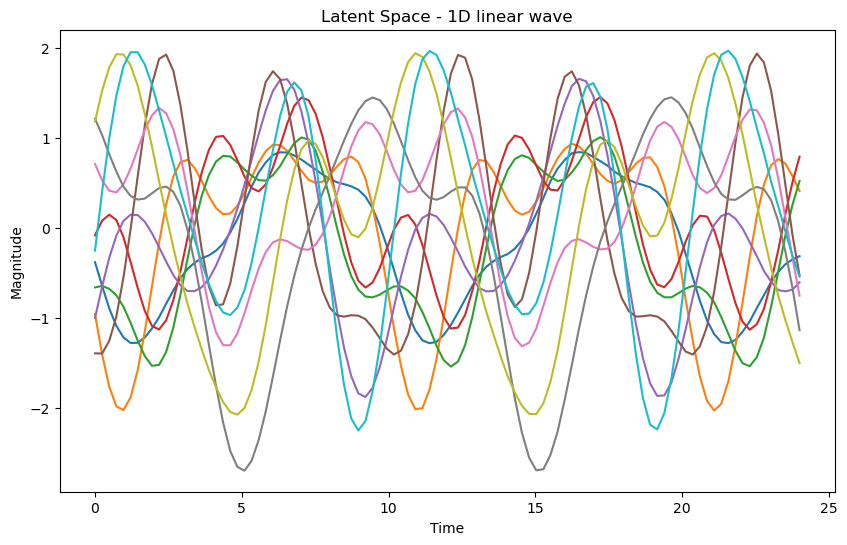

In [28]:
times = np.linspace(0,24,100)
plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(times,data_24_low[:,1000,i])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Latent Space - 1D linear wave')
# plt.plot(times,x2)

In [53]:
# time evolution
time_step = 99
x_test = data_24[0]#
ham_cons = []
ham_cons.append(hamiltonian(x_test))
z_test = test_model.project(x_test)
for i in range(time_step):
    y_test = test_model.embedding(z_test)
    ham_cons.append(hamiltonian(y_test))
    z_test = test_model.flowmapping(z_test)
    
y_test = test_model.embedding(z_test)
ham_cons.append(hamiltonian(y_test))

In [54]:
ham_cons = tf.concat(ham_cons,axis=1)
ham_cons.shape

TensorShape([3000, 101])

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


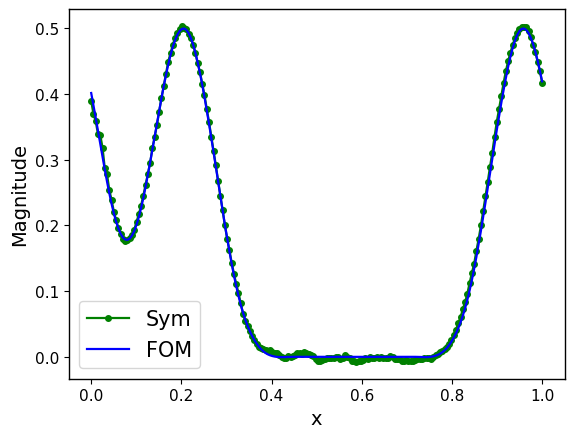

In [37]:
plt.figure()
x = np.linspace(0,1,n_x)
plt.plot(x,y_test[0,:n_x],c='g',marker='o',markersize=4,label='Sym')
plt.plot(x,data_24[99,0,:n_x],c='b',linestyle='-',label='FOM')
plt.xlabel('x')
plt.ylabel('Magnitude')
plt.legend(loc='best')
plt.show()

In [57]:
#choose one trajectory, show the evolution of hamiltonian 
index = 100
ham_label = hamiltonian(data_24[:,index])
plt.figure(figsize=(8,6))
plt.plot(times,ham_cons[index,:],c='g', marker='o', markersize=6, label='Sym')
plt.plot(times,ham_label,c='b', linestyle='-', label='Exact')
# plt.plot(times,ham_cons[2,1:],c='y',label='Sample = 2')
plt.xlabel('Time')
# plt.ylabel('Magnitude')
plt.legend(loc='best')
plt.ylim(0.1,0.4)
# plt.title('Relative Error:')
plt.title('Hamiltonian')
plt.ylabel('H(t)')
plt.show()

TensorShape([100, 1])